# 第9章: RNN, CNN

In [1]:
import pandas as pd
import numpy as np
import re
import random as rd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt

## 80. ID番号への変換

In [ ]:
vec_count = CountVectorizer()

In [ ]:
train = pd.read_csv('train.txt',delimiter='\t')
valid = pd.read_csv('valid.txt',delimiter='\t')
test = pd.read_csv('test.txt',delimiter='\t')

In [ ]:
def preprocess(text):
  text = text.lower()
  text = re.sub(r"[.?!-/:;\"]",'',text)
  text = re.sub(r"[0-9]","",text)
  return text

def featureExtractFT(df):
  title = df.TITLE
  title_processed = [preprocess(x) for x in title]
  X = vec_count.fit_transform(title_processed)
  return X.toarray()

def featureExtractT(df):
  title = df.TITLE
  title_processed = [preprocess(x) for x in title]
  X = vec_count.transform(title_processed)
  return X.toarray()

In [ ]:
train_extracted = pd.DataFrame(featureExtractFT(train), columns=vec_count.get_feature_names())
valid_extracted = pd.DataFrame(featureExtractT(valid), columns=vec_count.get_feature_names())
test_extracted = pd.DataFrame(featureExtractT(test), columns=vec_count.get_feature_names())

In [ ]:
train_dict = dict(train_extracted.sum())
train_ID_dict = {word[0]:i+1 for i, word in enumerate(sorted(train_dict.items(), key=lambda item:item[1], reverse=True))}
train_freq_dict = {word:freq for word,freq in sorted(train_dict.items(), key=lambda item:item[1], reverse=True)}

In [ ]:
def word_ID(word):
  if word not in train_ID_dict.keys() or train_freq_dict[word] < 2:
    return 0
  return train_ID_dict[word]

def dataset_to_ids(dataset):
  id_list = []
  for sentence in dataset:
    sentence_id_list = []
    for word in sentence:
        sentence_id_list.append(word_ID(word))
    id_list.append(torch.tensor(sentence_id_list))
  return id_list

def cat_convert(df,filename):
  cat_list_num = list(map(lambda x:{'b':0,
                               't':1,
                               'e':2,
                               'm':3}[x], df["CATEGORY"]))
  vec = torch.tensor(cat_list_num)
  torch.save(vec, filename)
  return vec

In [ ]:
train_cat = cat_convert(train, "Ytrain.pt")
valid_cat = cat_convert(valid, "Yvalid.pt")
test_cat = cat_convert(test, "Ytest.pt")

In [ ]:
train_processed = [preprocess(x).split() for x in train.TITLE]
train_id = dataset_to_ids(train_processed)
train_id[:5]

[tensor([2055, 1016,  780,  650, 6006,    6,  536, 1132,   40]),
 tensor([   8, 1591,  281,   12,  100,    6,  768, 1682, 7656, 3318]),
 tensor([ 160, 1788, 3423,    1, 7243,  319, 3931,   11,  184,    0]),
 tensor([ 762, 1480,   13, 1405,    0,  190,  498,   11, 3435,    0]),
 tensor([ 286,  368,  286,  368, 6503, 4453,  240])]

In [ ]:
valid_processed = [preprocess(x).split() for x in valid.TITLE]
valid_id = dataset_to_ids(valid_processed)
valid_id[:5]

[tensor([  47,   48,   47,   48, 2615,    2,   22, 7696,   14,  483, 3241]),
 tensor([   9, 4881,   36,  105,    7,  239, 2479]),
 tensor([6601, 4644,    0, 6601, 4644,    0,  331,  121,    8,  571]),
 tensor([ 264,  962,  151, 5997,    0,    6,    0]),
 tensor([   9,  316, 1819, 2945,    2,   33,  153, 4009,  448,  141])]

In [ ]:
test_processed = [preprocess(x).split() for x in test.TITLE]
test_id = dataset_to_ids(test_processed)
test_id[:5]

[tensor([2412, 3502, 3359,    0,   63,   11,  109, 1905,   43]),
 tensor([   3,    0, 1035,    5,    0,  118,   74,   49,  166, 4467,  424,  256,
            0,  353,  317,    1,    0]),
 tensor([1633,   42, 1022,  346,   15,  621,  559, 4411,    0,    0]),
 tensor([3630,    0,    6,  382,    8,  112,  170,  468]),
 tensor([ 236, 3202, 1014,   14,  798,    7, 3884, 1517,   75,  655, 2428, 2867])]

## 81. RNNによる予測

In [ ]:
# Hyper-parameters
batch_size = 100
num_epochs = 10
learning_rate = 0.001
input_size = len(train_id) + 1
hidden_size = 50
output_size = 4
emb_size = 300
device = torch.device('cpu')
padding_idx = len(train_id)

# Data loader
train_loader = torch.utils.data.DataLoader((train_id, train_cat), batch_size=1)
valid_loader = torch.utils.data.DataLoader((valid_id, valid_cat), batch_size=1)
test_loader = torch.utils.data.DataLoader((test_id, test_cat), batch_size=1)

In [ ]:
class RNN(nn.Module):
  def __init__(self,input_size,hidden_size,output_size,emb_size,padding_idx):
    super(RNN,self).__init__()
    self.hidden_size = hidden_size
    self.padding_idx = padding_idx
    self.device = device
    self.emb = nn.Embedding(input_size, emb_size, padding_idx)
    self.rnn = nn.RNN(emb_size,hidden_size, nonlinearity='tanh', batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self,x):
    self.batch_size = x.size()[0]
    hidden = torch.zeros(1, self.batch_size, self.hidden_size).to(self.device)
    emb = self.emb(x)
    out, hidden = self.rnn(emb, hidden)
    out = self.fc(out[:,-1, :])
    return out

In [ ]:
model = RNN(input_size,hidden_size,output_size,emb_size,padding_idx)

In [ ]:
it = iter(train_loader)
train_x = next(it)
i = 0
for x in train_x:
  i += 1
  if i > 10:
    break
  print(F.softmax(model(x), -1))

tensor([[0.2101, 0.2546, 0.2779, 0.2574]], grad_fn=<SoftmaxBackward>)
tensor([[0.2479, 0.2321, 0.2061, 0.3139]], grad_fn=<SoftmaxBackward>)
tensor([[0.2595, 0.3021, 0.2349, 0.2034]], grad_fn=<SoftmaxBackward>)
tensor([[0.2113, 0.2824, 0.2992, 0.2071]], grad_fn=<SoftmaxBackward>)
tensor([[0.2784, 0.1923, 0.2347, 0.2945]], grad_fn=<SoftmaxBackward>)
tensor([[0.1998, 0.2530, 0.1613, 0.3860]], grad_fn=<SoftmaxBackward>)
tensor([[0.1642, 0.1758, 0.2462, 0.4138]], grad_fn=<SoftmaxBackward>)
tensor([[0.1886, 0.2995, 0.0843, 0.4276]], grad_fn=<SoftmaxBackward>)
tensor([[0.4786, 0.1185, 0.2224, 0.1805]], grad_fn=<SoftmaxBackward>)
tensor([[0.1564, 0.2289, 0.2641, 0.3506]], grad_fn=<SoftmaxBackward>)


## 82. 確率的勾配降下法による学習

In [ ]:
# Hyper-parameters
batch_size = 100
num_epochs = 5
learning_rate = 0.001
input_size = len(train_id)+1
padding_idx = len(train_id)
hidden_size = 50
output_size = 4
emb_size = 300
device = torch.device('cpu')
loss_fn = nn.CrossEntropyLoss()

# Data load
train_loader = torch.utils.data.DataLoader([(train_id[i], train_cat[i]) for i in range(len(train_id))])
valid_loader = torch.utils.data.DataLoader([(valid_id[i], valid_cat[i]) for i in range(len(valid_id))])
test_loader = torch.utils.data.DataLoader([(test_id[i], test_cat[i]) for i in range(len(test_id))])

In [ ]:
model = RNN(input_size,hidden_size,output_size,emb_size,padding_idx)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [22]:
def train_fn(model, loader, loss_fn, optimizer, device):
  model.to(device)
  model.train()
  for x, y in loader:
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss_val = loss_fn(y_pred, y)
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    
def eval_fn(model, loader, loss_fn, optimizer, device):
  model.to(device)
  model.eval()
  total_loss, total_count, matched_count = 0, 0, 0
  with torch.no_grad():
    for x, y in loader:
      x, y = x.to(device), y.to(device)
      y_pred = model(x)
      predicted = torch.argmax(y_pred, dim=-1)
      total_count += len(x)
      matched_count += (predicted == y).sum()
      total_loss += loss_fn(y_pred, y).item()
  loss = total_loss/len(loader)
  acc = matched_count/total_count
  return acc, loss

In [ ]:
for i in range(num_epochs):
  train_fn(model, train_loader, loss_fn, optimizer, device)
  train_acc, train_loss = eval_fn(model, train_loader, loss_fn, optimizer, device)
  valid_acc, valid_loss = eval_fn(model, valid_loader, loss_fn, optimizer, device)
  print('epoch {}:\n training loss = {},\n training accuarcy = {},\n validation loss = {},\n validation accuracy = {}'.format(i, train_loss, train_acc, valid_loss, valid_acc))

epoch 0:
 training loss = 1.0911082773828877,
 training accuarcy = 0.5344440340995789,
 validation loss = 1.1155099759023346,
 validation accuracy = 0.522455096244812
epoch 1:
 training loss = 0.9850923503169916,
 training accuarcy = 0.6124110817909241,
 validation loss = 1.0448980367335374,
 validation accuracy = 0.5778443217277527
epoch 2:
 training loss = 0.8300564701085578,
 training accuarcy = 0.6908461451530457,
 validation loss = 0.9493262088665192,
 validation accuracy = 0.6369760632514954
epoch 3:
 training loss = 0.7010189432398709,
 training accuarcy = 0.7439161539077759,
 validation loss = 0.8845893698172855,
 validation accuracy = 0.69386225938797
epoch 4:
 training loss = 0.581464229409346,
 training accuarcy = 0.7874391674995422,
 validation loss = 0.7819916088981721,
 validation accuracy = 0.7282934188842773


## 83. ミニバッチ化・GPU上での学習

In [ ]:
!nvidia-smi

In [18]:
class Padsequence():
  def __init__(self,padding_idx):
    self.padding_idx = padding_idx
  def __call__(self,batch):
    sorted_batch = sorted(batch, key=lambda x:x[0].shape[0],reverse=True)
    sequences = [x[0] for x in sorted_batch]
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=padding_idx)
    labels = torch.LongTensor([x[1] for x in sorted_batch])
    return (sequences_padded, labels)

In [ ]:
# Hyper-parameters
batch_size = 32
num_epochs = 5
learning_rate = 0.001
input_size = len(train_id)+1
padding_idx = len(train_id)
hidden_size = 50
output_size = 4
emb_size = 300
device = torch.device('cuda')
loss_fn = nn.CrossEntropyLoss()
model = RNN(input_size,hidden_size,output_size,emb_size,padding_idx)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


# Data load
train_loader = torch.utils.data.DataLoader([(train_id[i], train_cat[i]) for i in range(len(train_id))], batch_size=batch_size, shuffle=True,collate_fn=Padsequence(padding_idx))
valid_loader = torch.utils.data.DataLoader([(valid_id[i], valid_cat[i]) for i in range(len(valid_id))], batch_size=1)
test_loader = torch.utils.data.DataLoader([(test_id[i], test_cat[i]) for i in range(len(test_id))], batch_size=1)

In [ ]:
for i in range(num_epochs):
  train_fn(model, train_loader, loss_fn, optimizer, device)
  train_acc, train_loss = eval_fn(model, train_loader, loss_fn, optimizer, device)
  valid_acc, valid_loss = eval_fn(model, valid_loader, loss_fn, optimizer, device)
  print('epoch {}:\n training loss = {},\n training accuarcy = {},\n validation loss = {},\n validation accuracy = {}'.format(i, train_loss, train_acc, valid_loss, valid_acc))

Result from Google Colab:

epoch 0:
 training loss = 1.2477301066507123,
 training accuarcy = 0.44655561447143555,
 validation loss = 1.3839659215816171,
 validation accuracy = 0.30129164457321167
 
epoch 1:
 training loss = 1.2122587804308909,
 training accuarcy = 0.4464620053768158,
 validation loss = 1.3583823366112273,
 validation accuracy = 0.3214152157306671
 
epoch 2:
 training loss = 1.189802683042195,
 training accuarcy = 0.4471171796321869,
 validation loss = 1.340670065667713,
 validation accuracy = 0.33508050441741943
 
epoch 3:
 training loss = 1.1787518601931497,
 training accuarcy = 0.4519842863082886,
 validation loss = 1.3284344728248076,
 validation accuracy = 0.3452826738357544
 
epoch 4:
 training loss = 1.171654954284965,
 training accuarcy = 0.44824036955833435,
 validation loss = 1.3199934504622157,
 validation accuracy = 0.3528640866279602

## 84. 単語ベクトルの導入

In [ ]:
from gensim.models import KeyedVectors

wordvec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True)

In [ ]:
class RNN(nn.Module):
  def __init__(self,input_size,hidden_size,output_size,emb_size,padding_idx,emb_weight):
    super(RNN,self).__init__()
    self.hidden_size = hidden_size
    self.padding_idx = padding_idx
    self.device = device
    if emb_weight.all() != None:
      self.emb = nn.Embedding.from_pretrained(emb_weight, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(input_size, emb_size, padding_idx)
    self.rnn = nn.RNN(emb_size,hidden_size, nonlinearity='tanh', batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self,x):
    self.batch_size = x.size()[0]
    hidden = torch.zeros(1, self.batch_size, self.hidden_size).to(self.device)
    emb = self.emb(x)
    out, hidden = self.rnn(emb, hidden)
    out = self.fc(out[:,-1, :])
    return out

In [ ]:
vocab_size = len(train_ID_dict) + 1
emb_size = 300
weight_matrix = np.zeros((vocab_size, emb_size))
word_count = 0
device = torch.device('cpu')
num_epochs = 5

for i, word in enumerate(train_ID_dict.keys()):
  if word in wordvec_model[0]:
    weight_matrix[i] = torch.from_numpy(wordvec_model[word])
    word_count += 1
  else:
    weight_matrix[i] = torch.from_numpy(np.random.normal(size=(emb_size,)))
weight_matrix = torch.from_numpy(weight_matrix.astype((np.float32)))

print(weight_matrix.shape)

<ipython-input-44-023105c60a3a>:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if word in wordvec_model[0]:


torch.Size([13868, 300])


In [ ]:
model = RNN(input_size,hidden_size,output_size,emb_size,padding_idx,weight_matrix)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
trainer = train_fn(model, train_loader, loss_fn, optimizer, device)

In [ ]:
for i in range(num_epochs):
  train_fn(model, train_loader, loss_fn, optimizer, device)
  train_acc, train_loss = eval_fn(model, train_loader, loss_fn, optimizer, device)
  valid_acc, valid_loss = eval_fn(model, valid_loader, loss_fn, optimizer, device)
  print('epoch {}:\n training loss = {},\n training accuarcy = {},\n validation loss = {},\n validation accuracy = {}'.format(i, train_loss, train_acc, valid_loss, valid_acc))

epoch 0:
 training loss = 0.9546808156682418,
 training accuarcy = 0.6217708587646484,
 validation loss = 1.0056816065366085,
 validation accuracy = 0.5965569019317627
epoch 1:
 training loss = 0.7704353375705214,
 training accuarcy = 0.7176151275634766,
 validation loss = 0.8469054141712046,
 validation accuracy = 0.686377227306366
epoch 2:
 training loss = 0.6397958460804971,
 training accuarcy = 0.7704979181289673,
 validation loss = 0.7616921861455246,
 validation accuracy = 0.727544903755188
epoch 3:
 training loss = 0.5374969132179428,
 training accuarcy = 0.8041931986808777,
 validation loss = 0.7005287001514529,
 validation accuracy = 0.7567365169525146
epoch 4:
 training loss = 0.46378485085239557,
 training accuarcy = 0.8269374966621399,
 validation loss = 0.6703607153653204,
 validation accuracy = 0.7664670944213867


## 85. 双方向RNN・多層化

In [ ]:
class BiDirectRNN(nn.Module):
  def __init__(self,input_size,hidden_size,output_size,emb_size,padding_idx,emb_weight,num_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.padding_idx = padding_idx
    self.num_layers = num_layers
    self.device = device
    if emb_weight.all() != None:
      self.emb = nn.Embedding.from_pretrained(emb_weight, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(input_size, emb_size, padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, num_layers=num_layers, nonlinearity='tanh', batch_first=True, bidirectional=True)
    self.fc = nn.Linear(hidden_size*2, output_size)

  def forward(self,x):
    self.batch_size = x.size()[0]
    hidden = torch.zeros(6, self.batch_size, self.hidden_size).to(self.device)
    emb = self.emb(x)
    out, hidden = self.rnn(emb, hidden)
    out = self.fc(out[:,-1, :])
    return out

In [ ]:
model = BiDirectRNN(input_size,hidden_size,output_size,emb_size,padding_idx,weight_matrix,num_layers=3)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
trainer = train_fn(model, train_loader, loss_fn, optimizer, device)

In [ ]:
num_epochs = 30
train_acc_list, train_loss_list, valid_acc_list, valid_loss_list = [], [], [], []
for i in range(num_epochs):
  train_fn(model, train_loader, loss_fn, optimizer, device)
  train_acc, train_loss = eval_fn(model, train_loader, loss_fn, optimizer, device)
  valid_acc, valid_loss = eval_fn(model, valid_loader, loss_fn, optimizer, device)
  train_acc_list.append(train_acc)
  train_loss_list.append(train_loss)
  valid_acc_list.append(valid_acc)
  valid_loss_list.append(valid_loss)
#   print('epoch {}:\n training loss = {},\n training accuarcy = {},\n validation loss = {},\n validation accuracy = {}'.format(i, train_loss, train_acc, valid_loss, valid_acc))

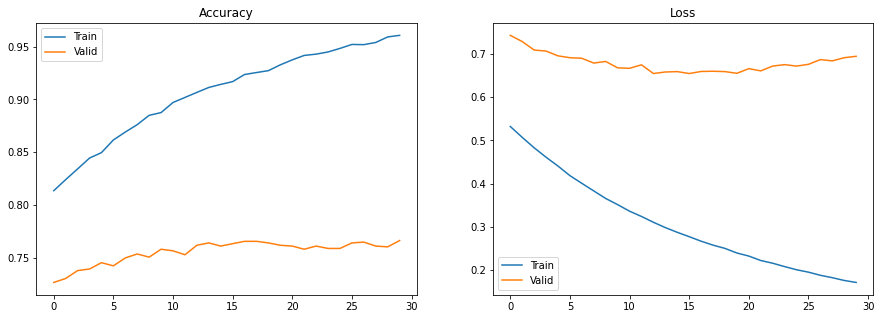

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(train_acc_list,label='Train')
axs[0].plot(valid_acc_list,label='Valid')
axs[1].plot(train_loss_list,label='Train')
axs[1].plot(valid_loss_list,label='Valid')
axs[0].set_title('Accuracy')
axs[1].set_title('Loss')
axs[0].legend()
axs[1].legend()
plt.show()

## 86. 畳み込みニューラルネットワーク (CNN)

In [ ]:
class CNN(nn.Module):
  def __init__(self,input_size,hidden_size,output_size,emb_size,batch_size,kernel_size,padding_idx,emb_weight):
    super().__init__()
    self.hidden_size = hidden_size
    if emb_weight.all() != None:
      self.emb = nn.Embedding.from_pretrained(emb_weight, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(input_size, emb_size, padding_idx)
    self.conv = nn.Conv1d(emb_size, hidden_size, kernel_size = kernel_size, stride = 1, padding=1)
    self.act = nn.ReLU()
    self.fc = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    emb = self.emb(x)
    conv = self.conv(emb.transpose(1,2))
    act = self.act(conv)
    max_pool = F.max_pool1d(act, act.shape[-1])
    max_pool_squeezed = max_pool.squeeze(2)
    out = self.fc(max_pool_squeezed)
    return out

In [ ]:
batch_size = 100
input_size = len(train_id)+1
padding_idx = len(train_id)
hidden_size = 10
output_size = 4
kernel_size = 3
emb_size = 300

model = CNN(input_size,hidden_size,output_size,emb_size,batch_size,kernel_size,padding_idx,weight_matrix)
train_loader = torch.utils.data.DataLoader([(train_id[i], train_cat[i]) for i in range(len(train_id))], batch_size=10, shuffle=True,collate_fn=Padsequence(padding_idx))

In [ ]:
train_x = next(iter(train_loader))[0]
model(train_x)

tensor([[ 0.9684,  1.1769, -0.1832, -0.1149],
        [ 1.2080,  1.1813, -0.0638,  0.0189],
        [ 1.0496,  0.9780, -0.3927, -0.4627],
        [ 1.2746,  1.1806, -0.5356, -0.3333],
        [ 0.9778,  1.0914, -0.2570,  0.4535],
        [ 1.0258,  1.1189, -0.4071, -0.0017],
        [ 0.8207,  1.0686, -0.2815,  0.0827],
        [ 1.1247,  1.1980, -0.4517,  0.0855],
        [ 1.4115,  1.3902, -0.3583,  0.0795],
        [ 0.9150,  0.9931, -0.3509,  0.1761]], grad_fn=<AddmmBackward>)

## 87. 確率的勾配降下法によるCNNの学習

In [ ]:
model = CNN(input_size,hidden_size,output_size,emb_size,batch_size,kernel_size,padding_idx,weight_matrix)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
trainer = train_fn(model, train_loader, loss_fn, optimizer, device)

In [ ]:
learning_rate = 0.001
num_epochs = 10
train_acc_list, train_loss_list, valid_acc_list, valid_loss_list = [], [], [], []
for i in range(num_epochs):
  train_fn(model, train_loader, loss_fn, optimizer, device)
  train_acc, train_loss = eval_fn(model, train_loader, loss_fn, optimizer, device)
  valid_acc, valid_loss = eval_fn(model, valid_loader, loss_fn, optimizer, device)
  train_acc_list.append(train_acc)
  train_loss_list.append(train_loss)
  valid_acc_list.append(valid_acc)
  valid_loss_list.append(valid_loss)
#   print('epoch {}:\n training loss = {},\n training accuarcy = {},\n validation loss = {},\n validation accuracy = {}'.format(i, train_loss, train_acc, valid_loss, valid_acc))

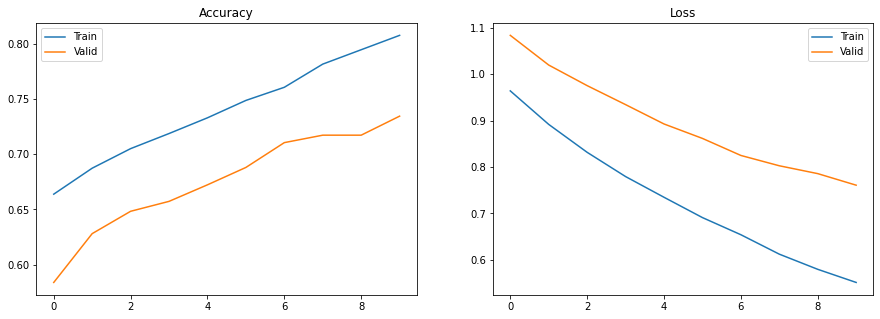

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(train_acc_list,label='Train')
axs[0].plot(valid_acc_list,label='Valid')
axs[1].plot(train_loss_list,label='Train')
axs[1].plot(valid_loss_list,label='Valid')
axs[0].set_title('Accuracy')
axs[1].set_title('Loss')
axs[0].legend()
axs[1].legend()
plt.show()

## 88. パラメータチューニング

In [ ]:
import optuna

def objective(trial):
  if trial.number == 15:
    study.stop()
  kernel_size = trial.suggest_categorical('kernel_size', [1,3,5])
  num_layers = trial.suggest_categorical("num_layers", [1,3,5])
  learning_rate = trial.suggest_categorical('learning_rate',[0.001,0.01])
  batch_size = int(trial.suggest_categorical('batch_size',[16,32,64]))
  
  # fixed parameters
  input_size = len(train_id)+1
  padding_idx = len(train_id)
  emb_size = 300
  hidden_size = 50
  output_size = 4
  num_epochs = 20

  loss_fn = nn.CrossEntropyLoss()
  model = CNN(input_size,hidden_size,output_size,emb_size,batch_size,kernel_size,padding_idx,weight_matrix)
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  trainer = train_fn(model, train_loader, loss_fn, optimizer, device)
  train_acc, train_loss = eval_fn(model, train_loader, loss_fn, optimizer, device)
  valid_acc, valid_loss = eval_fn(model, valid_loader, loss_fn, optimizer, device)
  return valid_loss

In [ ]:
study = optuna.create_study()
study.optimize(objective, timeout=1000)
trial = study.best_trial
print('Value: ', trial.value)
print('Params: ',study.best_params)
# trial = study.best_trial
# print('Value: ', trial.value)
# print('Params: ')
# for key, value in trial.params.items():
#   print(key,':',value)

[I 2021-06-22 15:23:29,950] A new study created in memory with name: no-name-6b7973d5-1f36-4b0e-8b90-64b8835ac76f
[I 2021-06-22 15:23:31,640] Trial 0 finished with value: 0.7254060738846174 and parameters: {'kernel_size': 1, 'num_layers': 1, 'learning_rate': 0.01, 'batch_size': 16}. Best is trial 0 with value: 0.7254060738846174.
[I 2021-06-22 15:23:35,861] Trial 1 finished with value: 0.7828708628364552 and parameters: {'kernel_size': 5, 'num_layers': 5, 'learning_rate': 0.01, 'batch_size': 32}. Best is trial 0 with value: 0.7254060738846174.
[I 2021-06-22 15:23:39,113] Trial 2 finished with value: 1.1417290577497667 and parameters: {'kernel_size': 3, 'num_layers': 3, 'learning_rate': 0.001, 'batch_size': 16}. Best is trial 0 with value: 0.7254060738846174.
[I 2021-06-22 15:23:40,737] Trial 3 finished with value: 0.7056854806539273 and parameters: {'kernel_size': 1, 'num_layers': 5, 'learning_rate': 0.01, 'batch_size': 32}. Best is trial 3 with value: 0.7056854806539273.
[I 2021-06-22

Value:  0.6911426700462036
Params:  {'kernel_size': 1, 'num_layers': 5, 'learning_rate': 0.01, 'batch_size': 32}


In [ ]:
input_size = len(train_id)+1
padding_idx = len(train_id)
emb_size = 300
hidden_size = 50
output_size = 4
num_epochs = 20
kernel_size = 1
num_layers = 5
learning_rate = 0.01
batch_size = 32

train_acc_list, train_loss_list, valid_acc_list, valid_loss_list = [], [], [], []
for i in range(num_epochs):
  train_fn(model, train_loader, loss_fn, optimizer, device)
  train_acc, train_loss = eval_fn(model, train_loader, loss_fn, optimizer, device)
  valid_acc, valid_loss = eval_fn(model, valid_loader, loss_fn, optimizer, device)
  train_acc_list.append(train_acc)
  train_loss_list.append(train_loss)
  valid_acc_list.append(valid_acc)
  valid_loss_list.append(valid_loss)

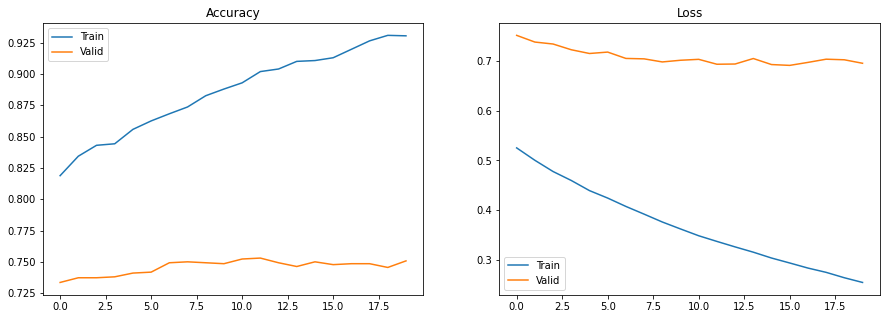

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(train_acc_list,label='Train')
axs[0].plot(valid_acc_list,label='Valid')
axs[1].plot(train_loss_list,label='Train')
axs[1].plot(valid_loss_list,label='Valid')
axs[0].set_title('Accuracy')
axs[1].set_title('Loss')
axs[0].legend()
axs[1].legend()
plt.show()

## 89. 事前学習済み言語モデルからの転移学習

In [2]:
!pip install transformers
!pip install sentencepiece
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [5]:
class BertDataset(torch.utils.data.Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y
  def __len__(self):
    return len(self.y)
  def __getitem__(self, index):
    return (self.x[index], self.y[index])
  def collate(batch):
    x = tokenizer([d[0] for d in batch], padding=True, return_tensors="pt")
    y = torch.stack([d[1] for d in batch], dim=-1)
    return {"x":x, "y":y}

In [6]:
def bert_read_to_dataset(filename):
  with open(filename) as f:
    dataset = f.read().splitlines()[1:]
  dataset = [line.split('\t') for line in dataset]
#   dataset_x = [tokenizer.encode(line[1]) for line in dataset]
  dataset_x = [line[1] for line in dataset]
#   dataset_y = [['b','t','e','m'].index(line[4]) for line in dataset]
#   dataset_x = [torch.tensor(tokenizer.encode(line[1]), dtype=torch.long) for line in dataset]
  dataset_y = torch.tensor([['b','t','e','m'].index(line[4]) for line in dataset], dtype=torch.long)
  return BertDataset(dataset_x, dataset_y)

In [7]:
bert_train = bert_read_to_dataset('train.txt')
bert_test = bert_read_to_dataset('test.txt')
bert_valid = bert_read_to_dataset('valid.txt')

In [8]:
class BertClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    config = BertConfig.from_pretrained('bert-base-cased', num_labels = 4)
    self.bert = BertForSequenceClassification.from_pretrained('bert-base-cased', config=config)
  def forward(self, x, labels=None):
#     padded = padding(batch)
#     attention_mask = masking(padded)
    out = self.bert(**x, labels=labels)
    return out

In [89]:
train_loader = torch.utils.data.DataLoader(bert_train, batch_size=20, collate_fn = BertDataset.collate)
bert_model = BertClassifier()

batch = iter(train_loader).__next__()
x = batch['x']
y = batch['y']
out = bert_model(x,y)
optimizer = optim.AdamW(bert_model.parameters(), lr=0.1)
loss_fn = nn.CrossEntropyLoss()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [93]:
def train_fn(model, loader, loss_fn, optimizer, device):
  model.to(device)
  model.train()
  loss_val, acc_val = 0, 0
  total_loss, total_count, total_acc = 0, 0, 0
  i = 0
  for batch in loader:
    x = batch['x'].to(device)
    y = batch['y'].to(device)
    model.zero_grad()
    out = model(x, y)
    loss_val = out.loss
    acc_val = (out.logits.argmax(dim = -1)==y).sum()
    total_count += len(x['input_ids'])
    total_loss = len(x['input_ids']) * loss_val.item()
    loss_val.backward()
    total_acc += acc_val
    optimizer.zero_grad()
    optimizer.step()
  final_loss = total_loss/total_count
  final_acc = total_acc/total_count
#   print('train acc: {}, train loss: {}'.format(final_acc, final_loss))
  return final_acc, final_loss
    
def eval_fn(model, loader, loss_fn, optimizer, device):
  model.to(device)
  model.eval()
  loss_val, acc_val = 0, 0
  total_loss, total_count, total_acc = 0, 0, 0
  with torch.no_grad():
    for batch in loader:
      x = batch['x'].to(device)
      y = batch['y'].to(device)
      out = model(x, y)
      loss_val = out.loss
      acc_val = (out.logits.argmax(dim = -1)==y).sum()
      total_count += len(x['input_ids'])
      total_acc += acc_val
      total_loss += loss_val.item() * len(x['input_ids'])
  final_loss = total_loss/total_count
  final_acc = total_acc/total_count
  print('valid acc: {}, valid loss: {}'.format(final_acc, final_loss))
  return final_acc, final_loss

In [94]:
train_loader = torch.utils.data.DataLoader(bert_train, batch_size = 128, collate_fn=BertDataset.collate)
valid_loader = torch.utils.data.DataLoader(bert_valid, batch_size = 32, collate_fn=BertDataset.collate)

In [95]:
# learning_rate = 0.001
train_acc_list, train_loss_list, valid_acc_list, valid_loss_list = [], [], [], []
num_epochs = 5
for i in range(num_epochs):
  device = 'cpu'
  train_acc, train_loss = train_fn(bert_model, train_loader, loss_fn, optimizer, device)
  valid_acc, valid_loss = eval_fn(bert_model, valid_loader, loss_fn, optimizer, device)
  train_acc_list.append(train_acc)
  train_loss_list.append(train_loss)
  valid_acc_list.append(valid_acc)
  valid_loss_list.append(valid_loss)
  print('epoch {}:\n training loss = {},\n training accuarcy = {},\n validation loss = {},\n validation accuracy = {}'.format(i, train_loss, train_acc, valid_loss, valid_acc))

valid acc: 0.41242516040802, valid loss: 1.3310500597525499
epoch 0:
 training loss = 0.007226225902238886,
 training accuarcy = 0.4102396070957184,
 validation loss = 1.3310500597525499,
 validation accuracy = 0.41242516040802
valid acc: 0.43862274289131165, valid loss: 1.3376867592691661
epoch 1:
 training loss = 0.007406983291643115,
 training accuarcy = 0.400879830121994,
 validation loss = 1.3376867592691661,
 validation accuracy = 0.43862274289131165
valid acc: 0.419910192489624, valid loss: 1.3536086939052194
epoch 2:
 training loss = 0.007503236870960277,
 training accuarcy = 0.37008610367774963,
 validation loss = 1.3536086939052194,
 validation accuracy = 0.419910192489624
valid acc: 0.41017964482307434, valid loss: 1.363506193646414
epoch 3:
 training loss = 0.007659006502600655,
 training accuarcy = 0.33648446202278137,
 validation loss = 1.363506193646414,
 validation accuracy = 0.41017964482307434
valid acc: 0.408682644367218, valid loss: 1.368155502273651
epoch 4:
 train